In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.linear_model as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import accuracy_score
%matplotlib inline
import matplotlib.pyplot as plt
import nltk
from nltk import tokenize
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import pickle
from wordcloud import WordCloud
from string import punctuation

In [2]:
tweets=pd.read_csv("Datasets/imdb-reviews-pt-br.csv")

In [3]:
tweets.head()

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg


In [4]:
sentimento=tweets["sentiment"].replace(["neg","pos"],[0,1])

In [5]:
tweets["sentimento"]=sentimento
tweets.head()

,id,text_en,text_pt,sentiment,sentimento
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg,0
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg,0
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg,0
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg,0
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg,0


In [6]:
print(tweets["sentimento"].value_counts())

sentimento
0    24765
1    24694
Name: count, dtype: int64


In [7]:
vetorizar = CountVectorizer(lowercase=False,max_features=50)
bag_of_words = vetorizar.fit_transform(tweets["text_pt"])

In [8]:
print(bag_of_words.shape)

(49459, 50)


In [9]:
treino, teste, classe_treino, classe_teste = train_test_split(bag_of_words,
                                                              tweets["sentimento"],
                                                              random_state = 42)

In [10]:
print(treino.shape)
print(teste.shape)

(37094, 50)
(12365, 50)


In [11]:
regressao_logistica = LogisticRegression(solver = "lbfgs")
regressao_logistica.fit(treino, classe_treino)
previsao_teste = regressao_logistica.predict_proba(teste)
print(previsao_teste)

[[0.25696739 0.74303261]
 [0.72224991 0.27775009]
 [0.70076066 0.29923934]
 ...
 [0.46019618 0.53980382]
 [0.46166722 0.53833278]
 [0.61777927 0.38222073]]


In [12]:
previsao_teste_bol = previsao_teste[:,1] >= 0.5
print(previsao_teste_bol)

[ True False False ...  True  True False]


In [13]:
previsao_teste_int = previsao_teste_bol.astype(int)
print(previsao_teste_int)

[1 0 0 ... 1 1 0]


In [14]:
acuracia_teste = accuracy_score(classe_teste, previsao_teste_int)
print(acuracia_teste)

0.6583097452486858


In [15]:
todos_palavras = ' '.join([texto for texto in tweets["text_pt"]])

In [16]:
nuvem_palavras = WordCloud(width = 800, height = 500, max_font_size = 110,
                          collocations = False).generate(todos_palavras)

In [17]:
twweets_negativa = tweets.query("sentiment == 'neg'")
twweets_positivo = tweets.query("sentiment == 'pos'")

In [18]:
palavras_neg = ' '.join([texto for texto in twweets_negativa["text_pt"]])
nuvem_palavras = WordCloud(width=800, height=500, max_font_size=110,
                           collocations=False).generate(palavras_neg)

In [19]:
token_espaco = tokenize.WhitespaceTokenizer()
todas_palavras = ' '.join([texto for texto in tweets["text_pt"]])
frequencia = nltk.FreqDist(token_espaco.tokenize(todas_palavras))
df_frequencia = pd.DataFrame({"Palavra": list(frequencia.keys()),
                             "Frequência": list(frequencia.values())})

In [20]:
df_frequencia = df_frequencia.nlargest(columns = "Frequência", n = 10)
df_frequencia

,Palavra,Frequência
20,de,417651
14,que,325070
42,e,299743
3,o,244881
7,um,216410
102,a,210179
45,é,192381
200,em,132778
1,uma,130888
29,não,127915


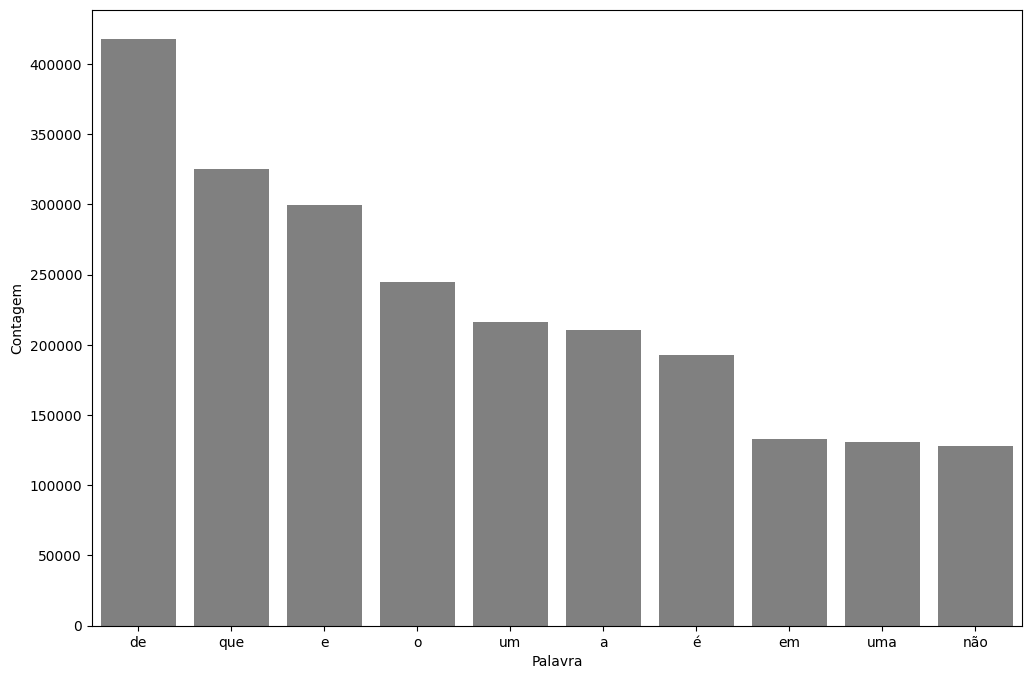

In [21]:
plt.figure(figsize=(12,8))
ax = sns.barplot(data = df_frequencia, x= "Palavra", y = "Frequência", color = 'gray')
ax.set(ylabel = "Contagem")
plt.show()

In [22]:
palavras_irrelevantes = nltk.corpus.stopwords.words("portuguese")
frase_processada = list()

for opiniao in tweets["text_pt"]:
    nova_frase = list()
    palavras_texto = token_espaco.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in palavras_irrelevantes:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))
    
tweets["tratamento_1"] = frase_processada

In [23]:
token_pontuacao = tokenize.WordPunctTokenizer()

In [24]:
pontuacao = list()
for ponto in punctuation:
    pontuacao.append(ponto)

pontuacao_stopwords = pontuacao + palavras_irrelevantes

frase_processada = list()
for opiniao in tweets["tratamento_1"]:
    nova_frase = list()
    palavras_texto = token_pontuacao.tokenize(opiniao)
    for palavra in palavras_texto:
        if palavra not in pontuacao_stopwords:
            nova_frase.append(palavra)
    frase_processada.append(' '.join(nova_frase))
    
tweets["tratamento_2"] = frase_processada

In [25]:
def classificar_texto(texto, coluna_texto, coluna_classificacao):
    vetorizar = CountVectorizer(lowercase=False, max_features=50)
    bag_of_words = vetorizar.fit_transform(texto[coluna_texto])
    treino, teste, classe_treino, classe_teste = train_test_split(bag_of_words,
                                                                 texto[coluna_classificacao],
                                                                 random_state = 42)
    
    regressao_logistica = LogisticRegression(solver="lbfgs")
    regressao_logistica.fit(treino, classe_treino)
    
    return regressao_logistica.score(teste, classe_teste)

In [28]:
#Sem Tratamento
acuracia_teste = classificar_texto(tweets, "text_pt", "sentimento")
print(acuracia_teste)

0.6583097452486858


In [27]:
#tratamento de Tirar palavras irelevantes
acuracia_teste = classificar_texto(tweets, "tratamento_1", "sentimento")
print(acuracia_teste)

0.6811160533764659


In [26]:
#Tratamento de Tirar pontuacao
acuracia_teste = classificar_texto(tweets, "tratamento_2", "sentimento")
print(acuracia_teste)

0.6892033966841893


In [29]:
x = tweets["tratamento_2"].values
y = tweets["sentiment"].values

In [30]:
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(x)

In [31]:
model = MultinomialNB()
model.fit(train_vectors, y)

MultinomialNB()

In [32]:
# Salvar o modelo treinado em um arquivo
#with open('model.pkl', 'wb') as file:
#    pickle.dump(model, file)

In [33]:
# Carregar o modelo treinado a partir do arquivo
#with open('model.pkl', 'rb') as file:
#    model = pickle.load(file)

In [34]:
def tratamento(text):
    frase_processada = list()
    for opiniao in text:
        nova_frase = list()
        palavras_texto = token_pontuacao.tokenize(opiniao)
        for palavra in palavras_texto:
            if palavra not in pontuacao_stopwords:
                nova_frase.append(palavra)
        frase_processada.append(' '.join(nova_frase))
    return frase_processada

In [35]:
def classifica_tweet(text):
    test_vectors = vectorizer.transform(tratamento(text))
    return model.predict(test_vectors)

In [36]:
text=['A Arena MRV vai virar um caldeirão, não tenha dúvida nenhuma. Você sabe como é a Massa do Atlético-MG. Eu fui a muitos estádios do Brasil e nunca vi uma arquibancada cantar o hino de um clube e eu ter a nítida impressão que o estádio iria desabar como faz a torcida do Atlético. Nunca vi.']

In [37]:
prediction = classifica_tweet(text)

print(prediction)

['pos']


In [38]:
text=['Já fui no jogo do Atlético e a torcida dos cara eh uma vergonha kkkkkkkkkkkkkkkkkkkkkkk']

In [39]:
prediction = classifica_tweet(text)

print(prediction)

['neg']


In [40]:
text=['como eu amo esses caras']

In [41]:
prediction = classifica_tweet(text)

print(prediction)

['pos']


In [42]:
text=['como eu odeio esses caras']

In [43]:
prediction = classifica_tweet(text)

print(prediction)

['neg']
